## 1. Training centernet on train and validation set. 

And find the highest epoch.

In [25]:
import json

ann = json.load(open("/mnt/Documents/Dad/github/DUP/yolo_to_coco/output/train.json"))

bad = [a["category_id"] for a in ann["annotations"] if a["category_id"] not in [0,1,2]]
print("Invalid labels:", set(bad))


Invalid labels: set()


In [24]:
# !python /mnt/Documents/Dad/github/DUP/mmdetection_new/tools/train.py configs/_config_2026/UDP_centernet_train_val.py
!python /mnt/Documents/Dad/github/DUP/mmdetection_new/tools/train.py /mnt/Documents/Dad/github/DUP/mmdetection_new/configs/_config_2026/UDP_faster_rcnn_resnet50_train_val2.py

02/04 09:31:37 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.25 (main, Nov  3 2025, 22:33:05) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 736396110
    GPU 0: NVIDIA GeForce RTX 4080
    CUDA_HOME: /usr/local/cuda-11.8
    GCC: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0
    PyTorch: 2.1.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_6

In [ ]:
from mmengine.config import Config
from mmdet.registry import MODELS
from mmengine.runner import load_checkpoint
import torch

# 1. Load your config
cfg = Config.fromfile('configs/_config_2026/UDP_centernet_train_val.py')

# 2. Build the model architecture (currently random weights)
print("Building model...")
model = MODELS.build(cfg.model)

# 3. Check the Backbone Initialization Config
init_cfg = model.backbone.init_cfg
print(f"\n[Check 1] Backbone Init Config: {init_cfg}")

# 4. Prove the weights exist on your disk
import os
# MMDetection saves weights here by default
weight_path = os.path.expanduser("~/.cache/torch/hub/checkpoints/resnet50_msra-5891d200.pth")

if os.path.exists(weight_path):
    print(f"[Check 2] Weight file found at: {weight_path}")
    print("   -> The file exists, so MMDetection can load it.")
else:
    print(f"[Check 2] WARNING: Weight file NOT found at standard path.")

# 5. Simulate the loading process
print("\n[Check 3] Attempting to load weights into backbone...")
try:
    # This is exactly what MMDetection does internally
    model.backbone.init_weights()
    print("   -> SUCCESS! The backbone successfully loaded the pretrained weights.")
except Exception as e:
    print(f"   -> FAILED. Error: {e}")

print("\nVERIFICATION COMPLETE: If [Check 3] was SUCCESS, you are using the downloaded weights.")

## 2. Converting training output to csv

In [ ]:
import json
import pandas as pd

# 1. Define file paths
input_file  = '/mnt/Documents/Dad/github/DUP/mmdetection_new/work_dirs/centernet_r18_coco_udp_train_val_50_epoch/20260120_181216/vis_data/20260120_181216.log'
output_file = '/mnt/Documents/Dad/github/DUP/mmdetection_new/work_dirs/centernet_r18_coco_udp_train_val_50_epoch/20260120_181216/vis_data/20260120_181216.csv'

# 2. Load the data line by line
data = []
with open(input_file, 'r', encoding='utf-8') as f:
    for line in f:
        # Parse each line as a separate JSON object
        if line.strip():  # Skip empty lines
            data.append(json.loads(line))

# 3. Convert to DataFrame
# json_normalize will now work perfectly on the list 'data'
df = pd.json_normalize(data)

# 4. Save to CSV
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Successfully converted '{input_file}' to '{output_file}'")
print(f"Total rows: {len(df)}")

Successfully converted 'work_dirs/centernet_r18_coco_udp/20260120_181216/vis_data/20260120_181216.json' to 'work_dirs/centernet_r18_coco_udp/20260120_181216/vis_data/20260120_181216.csv'
Total rows: 1300


We found that, for the centernet with training and validation set, the best mAP was found on 50 epoch.

So we are going to combine the train and validation set and re-train for 50 epochs.


## 3. Training centernet 5 times

In [ ]:
# Run 5 training sessions with different seeds

import os
import subprocess

# CONFIGURATION
config_file   = "configs/_config_2026/UDP_centernet_TrainVal_test.py"
base_work_dir = "work_dirs/centernet_r18_TrainVal_5_times"

# RUN SEEDS 0 to 4
for seed in range(5):
    print(f"\n========================================")
    print(f" STARTING TRAINING: SEED {seed}")
    print(f"========================================\n")
    
    # Define a unique work directory for this seed
    work_dir = os.path.join(base_work_dir, f"seed{seed}")
    
    # Construct the command
    # We use cfg-options to overwrite the work_dir and randomness.seed dynamically
    cmd = [
        "python", "tools/train.py",
        config_file,
        f"--work-dir={work_dir}",
        f"--cfg-options",
        f"randomness.seed={seed}",
        f"randomness.deterministic=True"
    ]
    
    # Run the command
    subprocess.run(cmd, check=True)

print("\nAll 5 seeds completed successfully!")



## 4. Faster RCNN

We found the best epoch at 17.

Now we train with TrainVal set for 17 epoch.

In [ ]:
!python tools/train.py configs/_config_2026/UDP_faster_rcnn_train_val.py

run 5 times with seed from 0 to 4

In [ ]:
import os
import subprocess
import sys

# Configuration
config_file = "/mnt/Documents/Dad/github/DUP/mmdetection_new/configs/_config_2026/UDP_faster_rcnn_TranVal_test.py"
base_work_dir = "/mnt/Documents/Dad/github/DUP/mmdetection_new/work_dirs/faster_rcnn_r18_TrainVal_17e"
seeds = [0, 1, 2, 3, 4]

# 1. SETUP ENVIRONMENT FOR DETERMINISTIC TRAINING
# This fixes the "RuntimeError: Deterministic behavior..." (CuBLAS error)
my_env = os.environ.copy()
my_env["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

for seed in seeds:
    print(f"\n{'='*50}")
    print(f" STARTING FASTER R-CNN TRAINING | SEED: {seed}")
    print(f"{'='*50}")

    work_dir = os.path.join(base_work_dir, f"seed{seed}")

    # 2. COMMAND CONSTRUCTION
    # In MMDetection v3, we use --cfg-options to change the seed
    cmd = [
        "python", "tools/train.py",
        config_file,
        "--work-dir", work_dir,
        "--cfg-options", f"randomness.seed={seed}" 
    ]

    try:
        # Run with the specific environment variable
        subprocess.run(cmd, check=True, env=my_env)
    except subprocess.CalledProcessError as e:
        print(f"❌ Seed {seed} FAILED with error code {e.returncode}.")
        sys.exit(1)

print("\n🎉 ALL 5 SEEDS COMPLETED SUCCESSFULLY!")

## 5. Inference to calculate mean & std

In [10]:
import os
import pandas as pd
from mmengine.config import Config
from mmengine.runner import Runner
from mmengine.logging import MMLogger

# ==============================================================================
# 1. SETUP PATHS & CONFIGS
# ==============================================================================
# Define the config files for both models
config_faster_rcnn = "configs/_config_2026/UDP_faster_rcnn_TranVal_test.py"
config_centernet   = "configs/_config_2026/UDP_centernet_TrainVal_test.py"

# Define the base directories where checkpoints are saved
# NOTE: Ensure these match your actual folder structure
dir_faster_rcnn = "work_dirs/faster_rcnn_r18_TrainVal_17e_5_times" 
dir_centernet   = "work_dirs/centernet_r18_TrainVal_5_times"

# Epochs to load
ckpt_faster = "epoch_17.pth"
ckpt_center = "epoch_50.pth"

# Seeds
seeds = [0, 1, 2, 3, 4]

# Where to save the PR curve .pkl files
pr_curve_dir = "work_dirs/pr_curve_data"
os.makedirs(pr_curve_dir, exist_ok=True)

results_data = []

# ==============================================================================
# 2. EVALUATION FUNCTION
# ==============================================================================
def run_evaluation(model_label, config_file, work_dir_base, ckpt_name, seeds):
    for seed in seeds:
        print(f"\n🚀 Processing {model_label} | Seed {seed}...")
        
        # 1. Path Setup
        ckpt_path = os.path.join(work_dir_base, f"seed{seed}", ckpt_name)
        if not os.path.exists(ckpt_path):
            print(f"   ⚠️ File not found: {ckpt_path}, skipping...")
            continue
            
        # 2. Load and Patch Config
        cfg = Config.fromfile(config_file)
        cfg.work_dir = os.path.join(work_dir_base, f"seed{seed}_eval")
        cfg.load_from = ckpt_path
        
        # --- KEY STEP 1: Enable Class-wise Metrics ---
        # This ensures we get mAP breakdown by class (U, D, P)
        if hasattr(cfg, 'test_evaluator'):
            cfg.test_evaluator.classwise = True
        else:
            # Fallback if config uses val_evaluator for testing
            cfg.val_evaluator.classwise = True
            cfg.test_evaluator = cfg.val_evaluator
            cfg.test_dataloader = cfg.val_dataloader

        # --- KEY STEP 2: Save Output for PR Curves ---
        # This saves a .pkl file which you need for drawing curves later
        pkl_save_path = os.path.join(pr_curve_dir, f"{model_label.replace(' ', '_')}_seed{seed}")
        # 'outfile_prefix' usually saves .json/.pkl files depending on metric type. 
        # For pure predictions needed for PR curves, we often rely on 'DumpDetResults' or similar, 
        # but standard CocoMetric often saves a json if format_only=False. 
        # Let's ensure we get the pickle by adding a DumpResults custom hook or relying on metric output.
        # Simplest way in v3 API:
        cfg.test_evaluator.outfile_prefix = pkl_save_path

        # 3. Build Runner & Test
        runner = Runner.from_cfg(cfg)
        metrics = runner.test()
        
        # 4. Extract Metrics
        # MMDetection returns keys like: 'coco/bbox_mAP', 'coco/bbox_mAP_50', etc.
        # Class-wise keys usually appear as 'coco/bbox_AP_50_class_{name}' OR we access the raw breakdown if available.
        # Note: If MMDetection doesn't return class keys in 'metrics', we rely on the printed logs for those,
        # but typically 'classwise=True' adds them to the dictionary.
        
        row = {
            "Model": model_label,
            "Seed": seed,
            "mAP_50 (Total)": metrics.get('coco/bbox_mAP_50', 0) * 100,
            "mAP_Small": metrics.get('coco/bbox_mAP_s', 0) * 100,
            "mAP_Medium": metrics.get('coco/bbox_mAP_m', 0) * 100,
            "mAP_Large": metrics.get('coco/bbox_mAP_l', 0) * 100,
        }
        
        # Try to find class-specific keys in the metrics dictionary
        # The keys depend on your class names defined in the config ('U', 'D', 'P')
        # They often look like 'coco/C_U_bbox_AP' or 'coco/bbox_AP_50_U' depending on MMDet version.
        # If they are not in the dict, we might need to manually inspect the log output.
        # For now, let's dump all keys to see what we get or check for common patterns.
        for key, val in metrics.items():
            if 'mAP_50' in key and key != 'coco/bbox_mAP_50':
                # Grab class specific (heuristic)
                short_key = key.replace('coco/bbox_mAP_50_', '')
                row[f"Class {short_key} (AP50)"] = val * 100
        
        results_data.append(row)
        print(f"   ✅ Saved PR file to: {pkl_save_path}.bbox.json (or .pkl)")

# ==============================================================================
# 3. RUN
# ==============================================================================

# Evaluate Faster R-CNN
run_evaluation("Faster R-CNN", config_faster_rcnn, dir_faster_rcnn, ckpt_faster, seeds)

# Evaluate CenterNet
# run_evaluation("CenterNet", config_centernet, dir_centernet, ckpt_center, seeds)

# ==============================================================================
# 4. DISPLAY RESULTS TABLE
# ==============================================================================
df = pd.DataFrame(results_data)

# Reorder columns for readability if possible
cols = ['Model', 'Seed', 'mAP_50 (Total)', 'mAP_Small', 'mAP_Medium', 'mAP_Large']
# Add dynamic class columns
cols += [c for c in df.columns if c not in cols]
df = df[cols]

print("\n" + "="*50)
print(" 📊 DETAILED RESULTS")
print("="*50)
print(df)

# Save to CSV
df.to_csv("final_metrics_classwise.csv", index=False)

print("\n📈 Averages:")
print(df.groupby("Model").mean(numeric_only=True))



#%%
# ==============================================================================
# 5. FORMAT RESULTS AS "MEAN ± STD"
# ==============================================================================

# Select only numeric columns for aggregation
numeric_cols = df.select_dtypes(include=['float64', 'int']).columns.tolist()

# Remove 'Seed' from aggregation if present
if 'Seed' in numeric_cols:
    numeric_cols.remove('Seed')

# Define a formatter function
def mean_std_format(x):
    m = x.mean()
    s = x.std()
    return f"{m:.2f} ± {s:.2f}"

# Group by Model and apply the formatter
summary_table = df.groupby("Model")[numeric_cols].agg(mean_std_format)

print("\n" + "="*60)
print(" 📋 FINAL REPORT: Mean ± Std (5 Seeds)")
print("="*60)
from IPython.display import display
display(summary_table)

# Save to CSV for your paper
summary_table.to_csv("final_paper_results_mean_std.csv")
print("\n✅ Saved table to 'final_paper_results_mean_std.csv'")


🚀 Processing Faster R-CNN | Seed 0...
01/21 11:25:38 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.25 (main, Nov  3 2025, 22:33:05) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1582725881
    GPU 0: NVIDIA GeForce RTX 4080
    CUDA_HOME: /usr/local/cuda-11.8
    GCC: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0
    PyTorch: 2.1.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compu

,mAP_50 (Total),mAP_Small,mAP_Medium,mAP_Large
Model,,,,
Faster R-CNN,95.12 ± 0.45,25.04 ± 3.26,61.24 ± 1.37,74.46 ± 0.99



✅ Saved table to 'final_paper_results_mean_std.csv'


## 6. Plot PR curve

Loading Ground Truth: /mnt/Documents/Dad/github/DUP/yolo_to_coco/output/test.json ...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Processing Faster R-CNN...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.03s).
Processing CenterNet...
Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.52s).
Accumulating evaluation results...
DONE (t=0.18s).


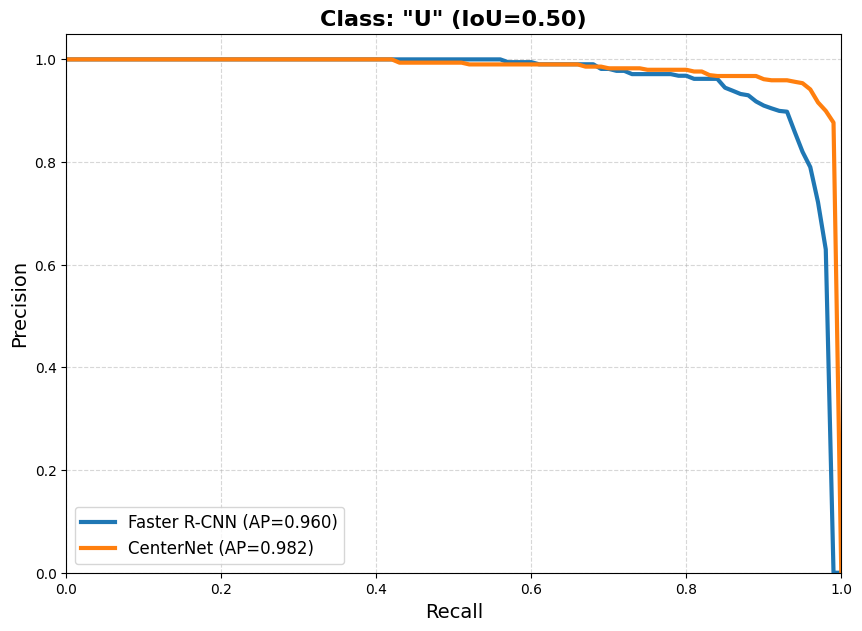

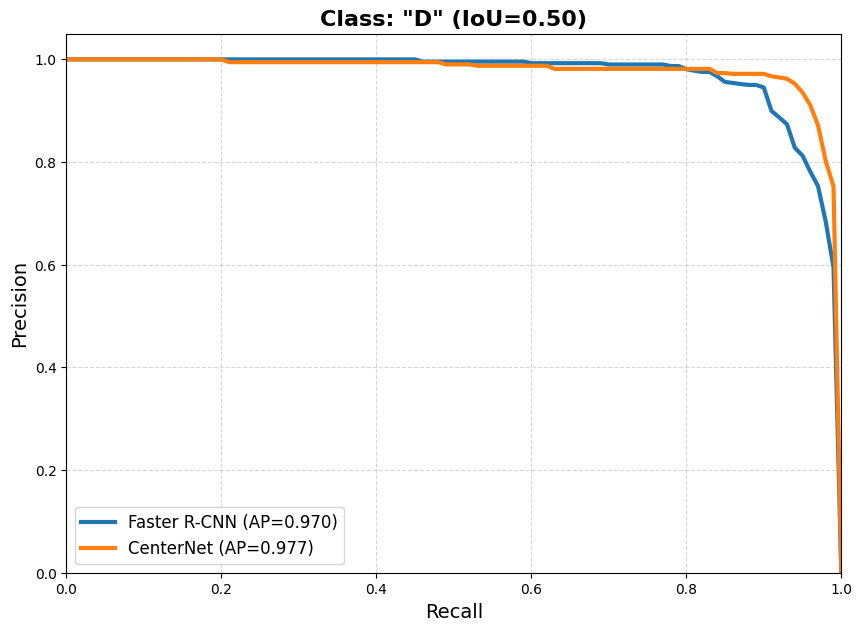

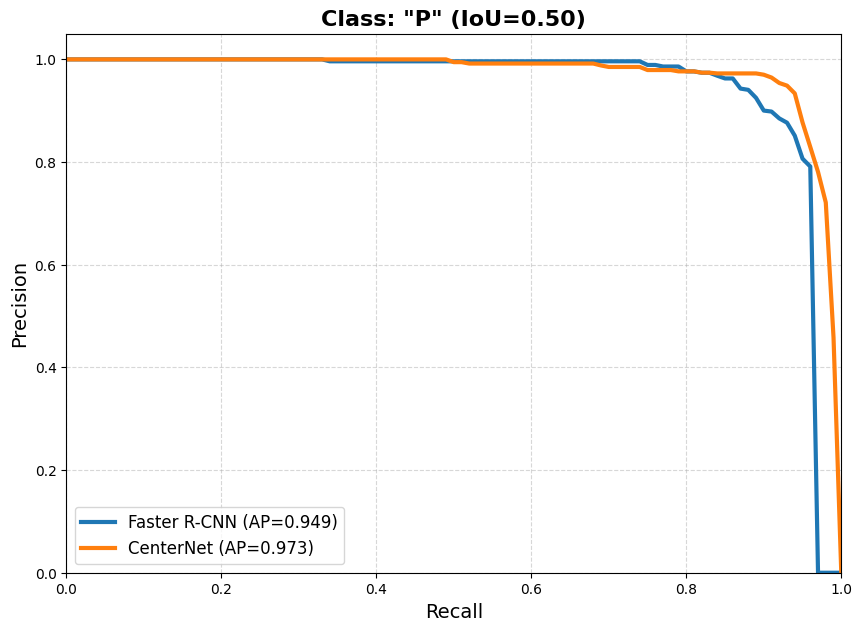

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Ensure plots display inline in Jupyter
%matplotlib inline 

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
gt_json_path = '/mnt/Documents/Dad/github/DUP/yolo_to_coco/output/test.json'

# Dictionary of models to compare
model_preds = {
    'Faster R-CNN': "work_dirs/pr_curve_data/Faster_R-CNN_seed0.bbox.json",
    'CenterNet':    "work_dirs/pr_curve_data/CenterNet_seed0.bbox.json"
}

class_names = ['U', 'D', 'P']

# ==============================================================================
# 2. HELPER: GET PRECISION DATA
# ==============================================================================
def get_precision_array(coco_gt, pred_json_path):
    try:
        # Load predictions using COCO API (suppress print output for cleaner notebook)
        coco_dt = coco_gt.loadRes(pred_json_path)
    except Exception as e:
        print(f"❌ Error loading {pred_json_path}: {e}")
        return None

    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    return coco_eval.eval['precision']

# ==============================================================================
# 3. MAIN PLOTTING LOOP
# ==============================================================================
def plot_comparison_per_class(gt_path, models_dict, classes):
    print(f"Loading Ground Truth: {gt_path} ...")
    coco_gt = COCO(gt_path)
    
    # Pre-load data for all models
    model_data = {}
    for model_name, pred_path in models_dict.items():
        print(f"Processing {model_name}...")
        precision = get_precision_array(coco_gt, pred_path)
        if precision is not None:
            model_data[model_name] = precision

    # X-Axis: Recall (0.0 to 1.0)
    x = np.arange(0.0, 1.01, 0.01)
    
    cat_ids = coco_gt.getCatIds()

    # --- LOOP THROUGH EACH CLASS ---
    for idx, cat_id in enumerate(cat_ids):
        current_class = classes[idx]
        
        # Create a new figure for this class
        plt.figure(figsize=(10, 7))
        
        # Plot line for each model
        for model_name, precision_matrix in model_data.items():
            # precision shape: [IoU, Recall, Class, Area, MaxDets]
            # Index [0, :, idx, 0, 2] corresponds to IoU=0.50, All Recalls, Current Class, All Areas, MaxDets=100
            pr_array = precision_matrix[0, :, idx, 0, 2]
            
            # Calculate approx AUC for legend
            auc = np.trapz(pr_array, x)
            
            plt.plot(x, pr_array, linewidth=3, label=f'{model_name} (AP={auc:.3f})')

        # Graph Styling
        plt.title(f'Class: "{current_class}" (IoU=0.50)', fontsize=16, fontweight='bold')
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.legend(fontsize=12, loc='lower left')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        
        # This command renders the plot in the notebook output
        plt.show() 

# ==============================================================================
# 4. EXECUTE
# ==============================================================================
plot_comparison_per_class(gt_json_path, model_preds, class_names)

Loading Ground Truth...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Evaluating Faster R-CNN...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
Evaluating CenterNet...
Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.57s).
Accumulating evaluation results...
DONE (t=0.19s).
Evaluating YOLOv9...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
Evaluating YOLOv7-tiny...
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.25s)

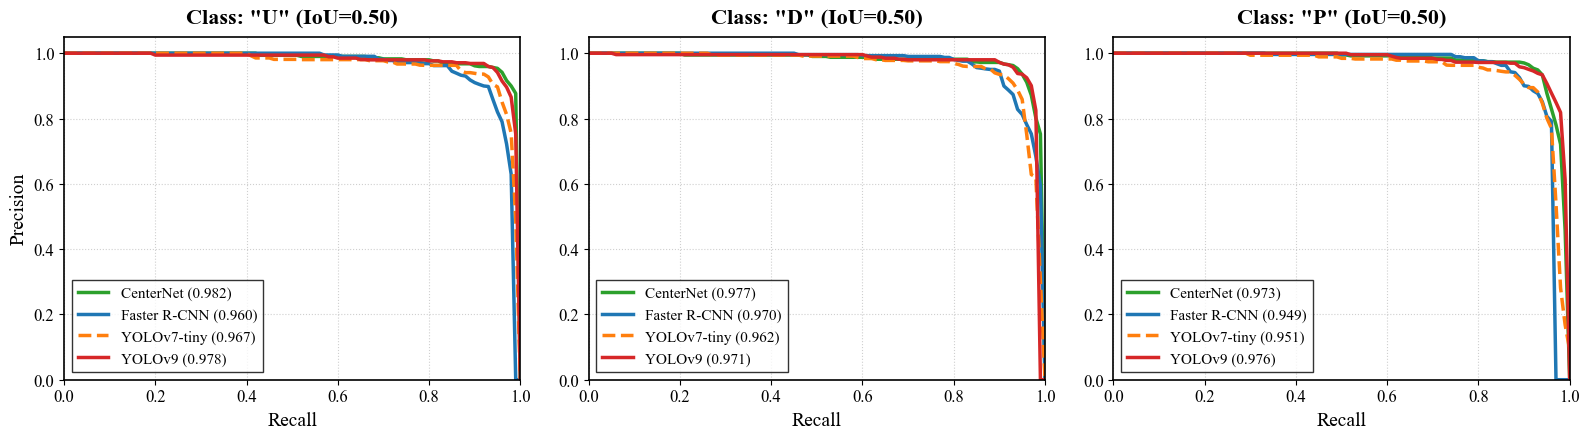

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

%matplotlib inline 

# ==============================================================================
# 1. STYLE CONFIGURATION
# ==============================================================================
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.linewidth'] = 1.2 # Slightly thicker borders

# ==============================================================================
# 2. CONFIGURATION
# ==============================================================================
gt_json_path = '/mnt/Documents/Dad/github/DUP/yolo_to_coco/output/test.json'

raw_preds = {
    'Faster R-CNN': "work_dirs/pr_curve_data/Faster_R-CNN_seed0.bbox.json",
    'CenterNet':    "work_dirs/pr_curve_data/CenterNet_seed0.bbox.json",
    'YOLOv9':       "work_dirs/yolov9_seed0.json",
    'YOLOv7-tiny':  "work_dirs/yolov7_tiny_seed0.json"
}

# EXACT ORDER REQUESTED
model_order = ['CenterNet', 'Faster R-CNN', 'YOLOv7-tiny', 'YOLOv9']

class_names = ['U', 'D', 'P']

# ==============================================================================
# 3. HELPER FUNCTIONS (Fixing & Loading)
# ==============================================================================
def fix_and_save_yolo(gt_obj, raw_path, fixed_path):
    if not os.path.exists(raw_path): return False
    
    # Map Filename -> ID
    name_to_id = {os.path.splitext(img['file_name'])[0]: mid for mid, img in gt_obj.imgs.items()}

    with open(raw_path, 'r') as f: preds = json.load(f)

    fixed_preds = []
    for p in preds:
        yolo_id = p['image_id']
        true_id = None
        
        # ID Fixing Logic
        if isinstance(yolo_id, str):
            if yolo_id in name_to_id: true_id = name_to_id[yolo_id]
            elif os.path.splitext(yolo_id)[0] in name_to_id: true_id = name_to_id[os.path.splitext(yolo_id)[0]]
        elif isinstance(yolo_id, int) and str(yolo_id) in name_to_id:
            true_id = name_to_id[str(yolo_id)]
            
        if true_id is not None:
            p['image_id'] = true_id
            # Cat Fixing Logic (0->1)
            if p['category_id'] == 0: p['category_id'] = 1
            elif p['category_id'] == 1: p['category_id'] = 2
            elif p['category_id'] == 2: p['category_id'] = 3
            fixed_preds.append(p)

    with open(fixed_path, 'w') as f: json.dump(fixed_preds, f)
    return True

def get_precision_array(coco_gt, pred_path):
    try:
        coco_dt = coco_gt.loadRes(pred_path)
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        return coco_eval.eval['precision']
    except: return None

# ==============================================================================
# 4. MAIN PLOTTING ROUTINE
# ==============================================================================
def run_paper_plots(gt_path, models_dict, model_order, classes):
    print("Loading Ground Truth...")
    coco_gt = COCO(gt_path)
    final_data = {}
    
    # --- Data Processing ---
    for model_name, raw_path in models_dict.items():
        path_to_use = raw_path
        if "yolo" in model_name.lower():
            fixed_path = raw_path.replace(".json", "_final_fixed.json")
            if os.path.exists(fixed_path): os.remove(fixed_path)
            if fix_and_save_yolo(coco_gt, raw_path, fixed_path): path_to_use = fixed_path
            else: continue

        if os.path.exists(path_to_use):
            print(f"Evaluating {model_name}...")
            precision = get_precision_array(coco_gt, path_to_use)
            if precision is not None: final_data[model_name] = precision

    # --- Plotting Setup ---
    x = np.arange(0.0, 1.01, 0.01)
    cat_ids = coco_gt.getCatIds()
    
    # Styles Dictionary
    styles = {
        'CenterNet':    {'color': '#2ca02c', 'ls': '-', 'lw': 2.5}, # Green
        'Faster R-CNN': {'color': '#1f77b4', 'ls': '-', 'lw': 2.5}, # Blue
        'YOLOv7-tiny':  {'color': '#ff7f0e', 'ls': '--','lw': 2.5}, # Orange Dashed
        'YOLOv9':       {'color': '#d62728', 'ls': '-', 'lw': 2.5}  # Red
    }

    # Create 1 Row, 3 Columns
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
    
    # Loop through subplots
    for i, ax in enumerate(axes):
        current_class = classes[i]
        cat_id = cat_ids[i]
        
        # Plot models in specific order
        for model_name in model_order:
            if model_name not in final_data: continue
            
            precision_matrix = final_data[model_name]
            # [IoU=0.5 (idx 0), All Recalls, Class idx, Area=All, MaxDets=100]
            pr_array = precision_matrix[0, :, i, 0, 2]
            auc = np.trapz(pr_array, x)
            
            s = styles.get(model_name, {})
            ax.plot(x, pr_array, label=f'{model_name} ({auc:.3f})', **s)

        # Subplot Formatting
        ax.set_title(f'Class: "{current_class}" (IoU=0.50)', fontsize=16, fontweight='bold', pad=10)
        ax.set_xlabel('Recall', fontsize=14)
        if i == 0:
            ax.set_ylabel('Precision', fontsize=14)
        
        ax.legend(fontsize=11, loc='lower left', frameon=True, fancybox=False, edgecolor='black')
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.15) # Reduce space between plots
    
    save_path = "pr_curve_combined_row.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ High-res figure saved to: {save_path}")
    plt.show()

# Run
run_paper_plots(gt_json_path, raw_preds, model_order, class_names)

Loading Ground Truth...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Evaluating Faster R-CNN...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.03s).
Evaluating CenterNet...
Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.53s).
Accumulating evaluation results...
DONE (t=0.18s).
Evaluating YOLOv9...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
Evaluating YOLOv7-tiny...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s)

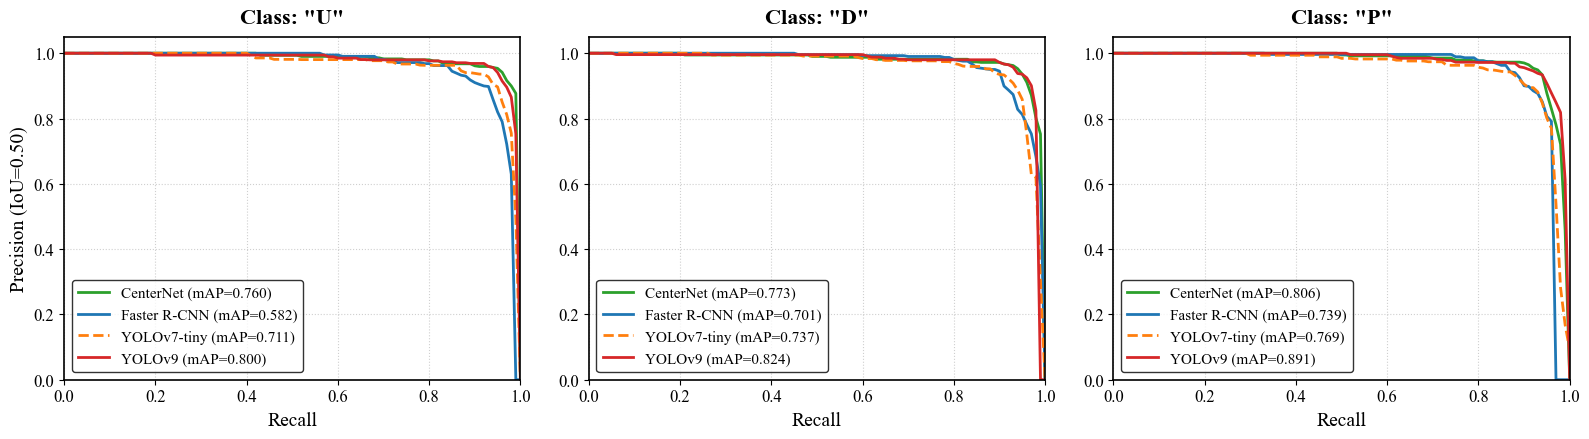

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

%matplotlib inline 

# ==============================================================================
# 1. STYLE CONFIGURATION
# ==============================================================================
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.linewidth'] = 1.2

# ==============================================================================
# 2. CONFIGURATION
# ==============================================================================
gt_json_path = '/mnt/Documents/Dad/github/DUP/yolo_to_coco/output/test.json'

raw_preds = {
    'Faster R-CNN': "work_dirs/pr_curve_data/Faster_R-CNN_seed0.bbox.json",
    'CenterNet':    "work_dirs/pr_curve_data/CenterNet_seed0.bbox.json",
    'YOLOv9':       "work_dirs/yolov9_seed0.json",
    'YOLOv7-tiny':  "work_dirs/yolov7_tiny_seed0.json"
}

# Order: CenterNet first, then others
model_order = ['CenterNet', 'Faster R-CNN', 'YOLOv7-tiny', 'YOLOv9']
class_names = ['U', 'D', 'P']

# ==============================================================================
# 3. HELPER FUNCTIONS
# ==============================================================================
def fix_and_save_yolo(gt_obj, raw_path, fixed_path):
    if not os.path.exists(raw_path): return False
    
    # Map Filename -> ID
    name_to_id = {os.path.splitext(img['file_name'])[0]: mid for mid, img in gt_obj.imgs.items()}

    with open(raw_path, 'r') as f: preds = json.load(f)

    fixed_preds = []
    for p in preds:
        yolo_id = p['image_id']
        true_id = None
        if isinstance(yolo_id, str):
            if yolo_id in name_to_id: true_id = name_to_id[yolo_id]
            elif os.path.splitext(yolo_id)[0] in name_to_id: true_id = name_to_id[os.path.splitext(yolo_id)[0]]
        elif isinstance(yolo_id, int) and str(yolo_id) in name_to_id:
            true_id = name_to_id[str(yolo_id)]
            
        if true_id is not None:
            p['image_id'] = true_id
            if p['category_id'] == 0: p['category_id'] = 1
            elif p['category_id'] == 1: p['category_id'] = 2
            elif p['category_id'] == 2: p['category_id'] = 3
            fixed_preds.append(p)

    with open(fixed_path, 'w') as f: json.dump(fixed_preds, f)
    return True

def get_precision_array(coco_gt, pred_path):
    try:
        coco_dt = coco_gt.loadRes(pred_path)
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        return coco_eval.eval['precision']
    except: return None

# ==============================================================================
# 4. PLOTTING ROUTINE (With mAP Calculation)
# ==============================================================================
def run_paper_plots(gt_path, models_dict, model_order, classes):
    print("Loading Ground Truth...")
    coco_gt = COCO(gt_path)
    final_data = {}
    
    # Process Models
    for model_name, raw_path in models_dict.items():
        path_to_use = raw_path
        if "yolo" in model_name.lower():
            fixed_path = raw_path.replace(".json", "_final_fixed.json")
            if os.path.exists(fixed_path): os.remove(fixed_path)
            if fix_and_save_yolo(coco_gt, raw_path, fixed_path): path_to_use = fixed_path
            else: continue

        if os.path.exists(path_to_use):
            print(f"Evaluating {model_name}...")
            precision = get_precision_array(coco_gt, path_to_use)
            if precision is not None: final_data[model_name] = precision

    x = np.arange(0.0, 1.01, 0.01)
    
    # Define Styles
    styles = {
        'CenterNet':    {'color': '#2ca02c', 'ls': '-', 'lw': 2},
        'Faster R-CNN': {'color': '#1f77b4', 'ls': '-', 'lw': 2},
        'YOLOv7-tiny':  {'color': '#ff7f0e', 'ls': '--','lw': 2},
        'YOLOv9':       {'color': '#d62728', 'ls': '-', 'lw': 2}
    }

    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
    
    for i, ax in enumerate(axes):
        current_class = classes[i]
        
        for model_name in model_order:
            if model_name not in final_data: continue
            
            # --- DATA EXTRACTION ---
            # precision shape: [10, 101, 3, 1, 100] (IoU, Recall, Class, Area, MaxDets)
            precision_matrix = final_data[model_name]
            
            # 1. Curve Data (Strictly IoU=0.50 for the visual line)
            pr_array_50 = precision_matrix[0, :, i, 0, 2]
            
            # 2. Legend Number (mAP 0.5:0.95)
            # We average across the first dimension (10 IoU thresholds)
            # Then average across all recalls
            # This approximates the COCO mAP metric for this class
            ap_50_95 = np.mean(precision_matrix[:, :, i, 0, 2])
            
            s = styles.get(model_name, {})
            
            # Plot the line (IoU=0.5) but Label with mAP (IoU=0.5:0.95)
            ax.plot(x, pr_array_50, label=f'{model_name} (mAP={ap_50_95:.3f})', **s)

        ax.set_title(f'Class: "{current_class}"', fontsize=16, fontweight='bold', pad=10)
        ax.set_xlabel('Recall', fontsize=14)
        if i == 0: ax.set_ylabel('Precision (IoU=0.50)', fontsize=14)
        
        ax.legend(fontsize=11, loc='lower left', frameon=True, edgecolor='black')
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.15)
    
    save_path = "pr_curve_paper_final.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

run_paper_plots(gt_json_path, raw_preds, model_order, class_names)